<a href="https://colab.research.google.com/github/sathya8998/sathya8998/blob/main/3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This assigments assumes you've been (at least partly) through [Assignment 1](https://colab.research.google.com/drive/132p1bYleoq71Za1gz7_iP5nDnRPKWeFo) which contains information about the assignment submission process. Basically you need to make a copy of the Python notebook and register it in the [assignments spreadsheet](https://docs.google.com/spreadsheets/d/1PDU5qpydm2psfCTbCu47lYSPKETS9h__ZsVm9BgQFJ4), after ensuring that my email `karolos.potamianos@cern.ch` has access.

***Please don't forget to tell me who you are:***

**NAME:**

**EMAIL:**

In this tutorial, we'll use the [mobile health (MHEALTH) dataset](https://archive.ics.uci.edu/ml/datasets/MHEALTH+Dataset). 

The goal is to predict the activity that people are doing based on the measurements from 23 channels (device outputs).



In [15]:
! [ ! -f MHEALTHDATASET.zip ] && wget https://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip || echo "Data already downloaded!"
! [ -d MHEALTHDATASET ] && echo "Data already extracted" || unzip MHEALTHDATASET.zip
! ls
! ls MHEALTHDATASET


# Let us get some information on the dataset

with open("MHEALTHDATASET/README.txt", encoding = "ISO-8859-1") as f:
  for l in f.readlines(): print(l)

Data already downloaded!
Data already extracted
CNN-Model.png  MHEALTHDATASET	   sample_data
GRU-Model.png  MHEALTHDATASET.zip  SimpleRNN.png
mHealth_subject10.log  mHealth_subject4.log  mHealth_subject8.log
mHealth_subject1.log   mHealth_subject5.log  mHealth_subject9.log
mHealth_subject2.log   mHealth_subject6.log  README.txt
mHealth_subject3.log   mHealth_subject7.log


*************************************************** mHealth dataset **********************************************************



Authors: Oresti Baños, Rafael Garcia, Alejandro Saez

Date: 22/10/2013

Institution: University of Granada (UGR) 

Department: Department of Computer Architecture and Computer Technology.

Contact: oresti@ugr.es (oresti.bl@gmail.com)



---------------------------------------------------------------------------------------------------------------------------------------------

NOTE: if you use this dataset please cite the following work



Banos, O., Garcia, R., Holgado-Terriza, J.A., Dama

Let us know have a look at the data output, to understand what we're dealing with. This image helps explain what we do: we make shorter sequences of 100 points (2s @ 50Hz) that we'll use to train.

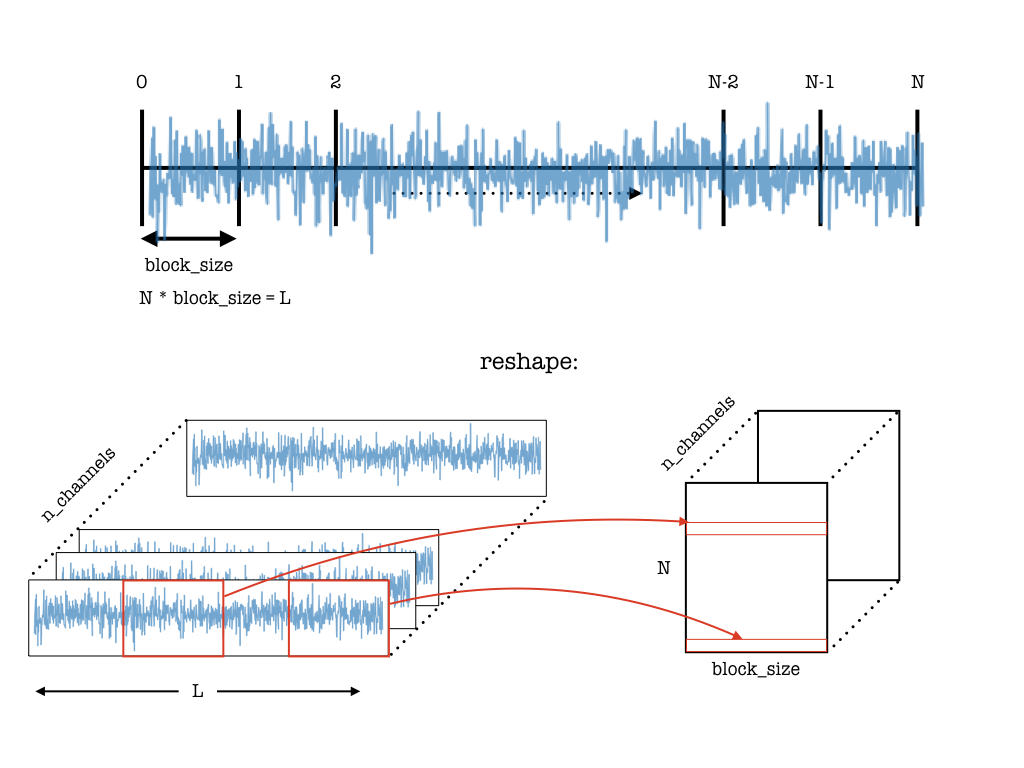


In [16]:
import pandas as pd
import numpy as np

def read_subject(i):
  print(f"Processing file MHEALTHDATASET/mHealth_subject{i}.log")
  data = pd.read_csv(f"MHEALTHDATASET/mHealth_subject{i}.log", delimiter='\t',header=None)
  # Removing null class
  data = data[data[23]!=0]
  return data

# Let's make blocks of 100 points (i.e. 2s worth of points)
def split_in_blocks(data, block_size=100):
  X_ = []
  y_ = []

  groups = data.groupby(23)
  n_channels = data.shape[1]-1

  for gid in range(1,len(groups)+1):
    y = pd.unique(groups.get_group(gid)[23].to_numpy())
    x = groups.get_group(gid).drop(23, axis=1).to_numpy()
    n_blocks = len(x) // block_size

    x = x[:n_blocks*block_size]
    y = y[:n_blocks*block_size]

    x_tensor = x.reshape(-1, block_size, n_channels)

    # Append
    X_.append(x_tensor)
    y_.append(np.array([y]*len(x_tensor), dtype=int).squeeze())

  # Concatenate and return
  X = np.concatenate(X_, axis=0)
  y = np.concatenate(y_, axis=0)
  return X, y

block_size = 100
# Creating lists to save data
X_ = []
y_ = []
for s in range(1,11):
  data = read_subject(s)
  X, y = split_in_blocks(data, block_size)
  X_.append(X)
  y_.append(y)
# Concatenate
X = np.concatenate(X_, axis=0)
y = np.concatenate(y_, axis=0)

print(X.shape, y.shape)

# Code to bring everything in in one go
# data_list = []
# for i in range(1,11):
#   data = read_subject(i)
#   data_list.append( data )
# data = pd.concat(data_list, axis=0, ignore_index=True)
# print(data.head())
# # Checking the shape of our data
# print(data.shape)
# for i in range(1,13):
#   print(f"{i}: {data[data[23]==i].shape}")

Processing file MHEALTHDATASET/mHealth_subject1.log
Processing file MHEALTHDATASET/mHealth_subject2.log
Processing file MHEALTHDATASET/mHealth_subject3.log
Processing file MHEALTHDATASET/mHealth_subject4.log
Processing file MHEALTHDATASET/mHealth_subject5.log
Processing file MHEALTHDATASET/mHealth_subject6.log
Processing file MHEALTHDATASET/mHealth_subject7.log
Processing file MHEALTHDATASET/mHealth_subject8.log
Processing file MHEALTHDATASET/mHealth_subject9.log
Processing file MHEALTHDATASET/mHealth_subject10.log
(3355, 100, 23) (3355,)


Now that `X` represents the data from the 23 channels and the `y` the activity identifier (from 1 to 12), we can use the dataset.

We now need to split our data between the *training* and *testing* samples.
(We might even go further as we have a lot of data points.)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=123)

# Standardize
def standardise(X): return (X - np.mean(X, axis=0)[None,:,:]) / np.std(X, axis=0)[None,:,:]

X_train = standardise(X_train)
X_test = standardise(X_test)

# Train/validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.4, stratify=y_train, random_state=456)

# One-hot encoding
def one_hot(labels, n_class): return np.eye(n_class)[:,labels-1].T

y_train = one_hot(y_train, n_class=12)
y_valid = one_hot(y_valid, n_class=12)
y_test = one_hot(y_test, n_class=12)

# Getting some numbers out
print("Training set size: ", len(X_train))
print("Validaton set size: ", len(X_valid))
print("Test set size: ", len(X_test))

Training set size:  1408
Validaton set size:  940
Test set size:  1007


Let us now train a network

(100, 23)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 100, 46)           2162      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 50, 46)           0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 50, 92)            8556      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 25, 92)           0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 25, 184)           84824     
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 5, 184)

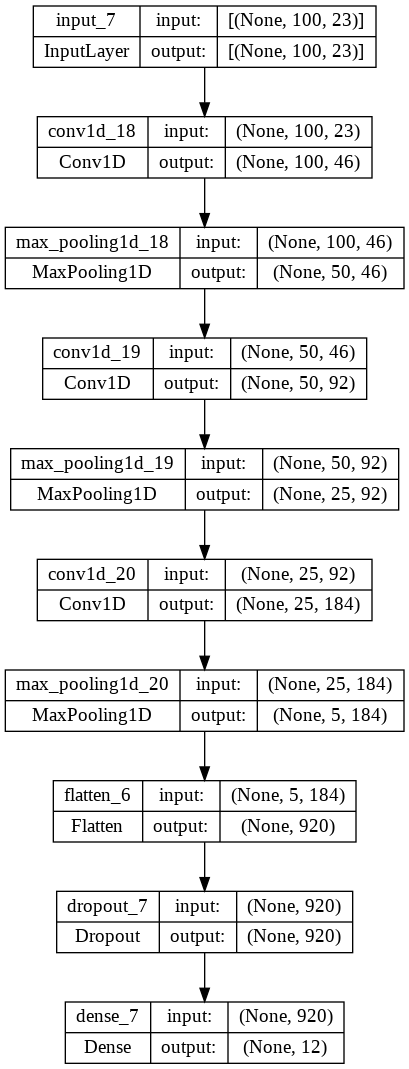

In [21]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

num_classes = 12
input_shape = (block_size, 23)
dropout_rate = 0.5
print(input_shape)
model = keras.Sequential(
    [
# Put your model here...
        keras.Input(shape=input_shape),
        layers.Conv1D(filters=46, kernel_size=2, strides=1,
              padding='same', activation="relu"),
        layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        layers.Conv1D(filters=92, kernel_size=2, strides=1,
              padding='same', activation="relu"),
        layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        layers.Conv1D(filters=184, kernel_size=5, strides=1,
              padding='same', activation="relu"),
        layers.MaxPooling1D(pool_size=5, strides=5, padding='same'),
        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation="softmax"),
    ]
)


# Shows a nice summary of the model
model.summary()

!pip install pydot
from tensorflow.keras.utils import plot_model

plot_model(model, 'CNN-Model.png', show_shapes=True)

Let's train our network.

In [22]:
batch_size = 128
epochs = 20

# Feel free to change parameters below if needed
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20
10/10 [==============================] - 2s 106ms/step - loss: 2.1518 - accuracy: 0.2541 - val_loss: 1.8208 - val_accuracy: 0.3901
Epoch 2/20
10/10 [==============================] - 1s 84ms/step - loss: 1.4386 - accuracy: 0.5683 - val_loss: 1.2217 - val_accuracy: 0.6879
Epoch 3/20
10/10 [==============================] - 1s 84ms/step - loss: 0.9459 - accuracy: 0.7167 - val_loss: 0.7287 - val_accuracy: 0.7943
Epoch 4/20
10/10 [==============================] - 1s 82ms/step - loss: 0.5613 - accuracy: 0.8335 - val_loss: 0.4400 - val_accuracy: 0.8865
Epoch 5/20
10/10 [==============================] - 1s 82ms/step - loss: 0.3517 - accuracy: 0.8974 - val_loss: 0.2466 - val_accuracy: 0.9433
Epoch 6/20
10/10 [==============================] - 1s 84ms/step - loss: 0.2326 - accuracy: 0.9345 - val_loss: 0.1651 - val_accuracy: 0.9645
Epoch 7/20
10/10 [==============================] - 1s 85ms/step - loss: 0.1585 - accuracy: 0.9534 - val_loss: 0.1353 - val_accuracy: 0.9716
Epoch 8/20
1

Let us plot the performance of our algorithm.

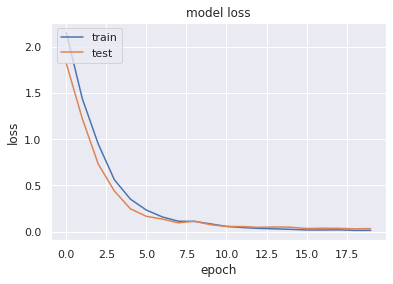

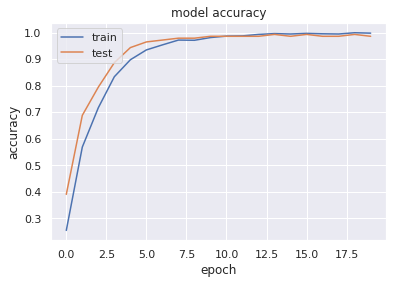

In [23]:
def plot_history(history):
  import matplotlib.pyplot as plt
  %matplotlib inline

  for k in [ 'loss', 'accuracy']:
    # summarize history for accuracy
    plt.plot(history.history[f'{k}'])
    plt.plot(history.history[f'val_{k}'])
    plt.title(f'model {k}')
    plt.ylabel(f'{k}')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(history)

1. Please provide some information on the performance of your model and a training.
**Answer:**

Obtaining the confusion matrix for the model.


32/32 [==============================] - 0s 8ms/step
Correcly classified 998 out of 1007 sequences (99.10625620655412%)


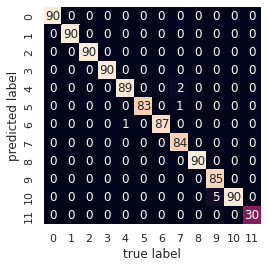

30/30 [==============================] - 0s 8ms/step
Correcly classified 929 out of 940 sequences (98.82978723404256%)


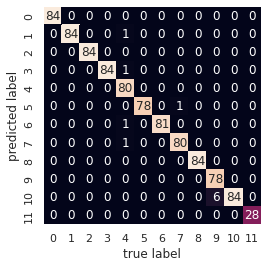

105/105 [==============================] - 1s 8ms/step
Correcly classified 3333 out of 3355 sequences (99.34426229508196%)


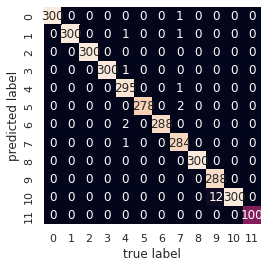

In [26]:
def analyse_classifier(model, X, y):
  yPred = model.predict(X, verbose=1)
  from sklearn.metrics import confusion_matrix
  # Don't forget that in our model we have labels from 1 to 12
  cm = confusion_matrix(y.argmax(axis=1)+1, yPred.argmax(axis=1)+1)

  import matplotlib.pyplot as plt
  %matplotlib inline
  import seaborn as sns; sns.set()
  sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  nTotal = len(y)
  nCorrect = np.count_nonzero(y.argmax(axis=1)-yPred.argmax(axis=1)==0)
  print(f"Correcly classified {nCorrect} out of {nTotal} sequences ({nCorrect/nTotal*100}%)")

  plt.show()

analyse_classifier(model, X_test, y_test)
analyse_classifier(model, X_valid, y_valid)

# Running on the complete dataset
# We first need to standardise our input (which we didn't do before)
X_std = standardise(X)
# And we need to conver the full y into one-hot notation
analyse_classifier(model, X_std, one_hot(y, n_class=12))

## Training another classifier

1. Can you train another model ?

 **Answer:**. Yes.With GRU 

Feel free to split into multiple text/code blocks.


2. Can you try yet another ?

 **Answer**  YES.With RNN

Try varying the parameters (copying to yet another cell ; don't forget to adjust the model variable to `model_3` or more).

GRU

(100, 23)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 100, 128)          58752     
                                                                 
 dropout_16 (Dropout)        (None, 100, 128)          0         
                                                                 
 gru_11 (GRU)                (None, 128)               99072     
                                                                 
 dense_18 (Dense)            (None, 12)                1548      
                                                                 
Total params: 159,372
Trainable params: 159,372
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
10/10 [==============================] - 13s 860ms/step - loss: 2.1074 - accuracy: 0.3268 - val_loss: 1.7531 - val_accuracy: 0.4610
Epoch 2/20
10/10 [========

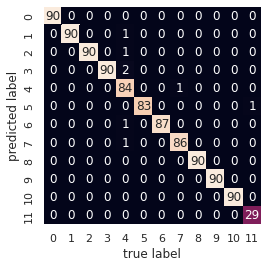

30/30 [==============================] - 2s 50ms/step
Correcly classified 928 out of 940 sequences (98.72340425531915%)


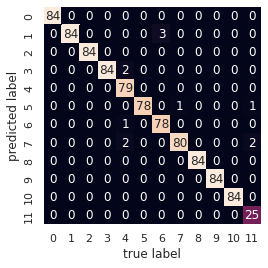

105/105 [==============================] - 5s 52ms/step
Correcly classified 3333 out of 3355 sequences (99.34426229508196%)


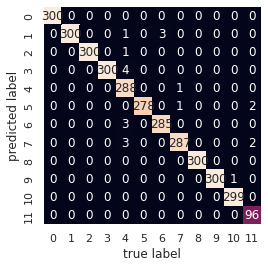

In [36]:
num_classes = 12
input_shape = (block_size, 23)
dropout_rate = 0.5
print(input_shape)
model_2 = keras.Sequential(
    [
    layers.GRU(128, input_shape=input_shape, return_sequences=True),
    layers.Dropout(0.3),
    layers.GRU(128),
    layers.Dense(num_classes, activation="softmax"),
    ]
)

# Shows a nice summary of the model
model_2.summary()
plot_model(model_2, 'GRU-Model.png', show_shapes=True)

batch_size = 128
epochs = 20

model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_2 = model_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

analyse_classifier(model_2, X_test, y_test)
analyse_classifier(model_2, X_valid, y_valid)

# And we need to conver the full y into one-hot notation
analyse_classifier(model_2, X_std, one_hot(y, n_class=12))

### RNN

(100, 23)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 100, 128)          19456     
                                                                 
 dropout_17 (Dropout)        (None, 100, 128)          0         
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 12)                1548      
                                                                 
Total params: 53,900
Trainable params: 53,900
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
10/10 [==============================] - 4s 272ms/step - loss: 2.0537 - accuracy: 0.3149 - val_loss: 1.4966 - val_accuracy: 0.4823
Epoch 2/20
10/10 [===========

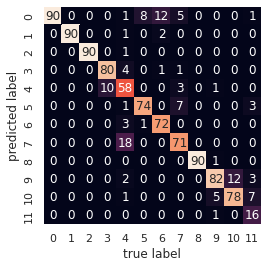

30/30 [==============================] - 1s 20ms/step
Correcly classified 833 out of 940 sequences (88.61702127659574%)


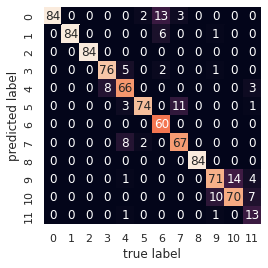

105/105 [==============================] - 2s 20ms/step
Correcly classified 3054 out of 3355 sequences (91.02831594634874%)


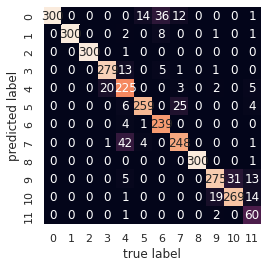

In [37]:
num_classes = 12
input_shape = (block_size, 23)
dropout_rate = 0.5
print(input_shape)
model_3 = keras.Sequential(
    [
    layers.SimpleRNN(128, input_shape=input_shape, return_sequences=True),
    layers.Dropout(0.3),
    layers.SimpleRNN(128),
    layers.Dense(num_classes, activation="softmax"),
    ]
)

# Shows a nice summary of the model
model_3.summary()
plot_model(model_2, 'GRU-Model.png', show_shapes=True)

batch_size = 128
epochs = 20

model_3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_3 = model_3.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

analyse_classifier(model_3, X_test, y_test)
analyse_classifier(model_3, X_valid, y_valid)

# And we need to conver the full y into one-hot notation
analyse_classifier(model_3, X_std, one_hot(y, n_class=12))

# Wrapping up

*Note: use this space for thoughts; this part is not part of the mark (unless you don't fill it at all).*

What did you take out from this?

**Answer:**